In [1]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Predict Gene Expression Part I: Feature Generation

This is the first of two notebooks which use 6-base data to predict gene expression in mouse embryonic stem cells ES-E14. We aim to use methylation data in a simple set of genomic regions (upstream regions, around TSSs, gene bodies, first exons and introns, other exons and introns, 5 and 3' UTRs, downstream regions, and CpG islands), and train a gene expression prediction model, using a [public dataset of expression](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135509). The regions are based on the Gencode annotations, for the mm10 mouse genome.

In this notebook, for each of the regions above, we compute a mean 5mC fraction, a mean 5hmC fraction, a record the number of CpGs in the region (regardless of whether they are methylated or not), and the length of the region. Thus, we capture 4 features per region.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns

[`modality`](https://modality-docs.biomodal.com/index.html) contains a set of functions to extract annotations from [GENCODE](https://www.gencodegenes.org/). Note that GENCODE only provides annotations for the Human and Mouse genomes, and the [`annotation`](https://modality-docs.biomodal.com/modality.html#module-modality.annotation) module of [`modality`](https://modality-docs.biomodal.com/index.html) only supports the hg38 (GRCh38), mm10 (GRCm38) and mm39 (GRCm39) genomes. In this notebook, we use mm10.

In [3]:
from modality.datasets import load_biomodal_dataset
from modality.annotation import (
    get_genes,
    get_transcription_end_region,
    get_tss_region,
    get_exons,
    get_introns,
    get_five_prime_utrs,
    get_three_prime_utrs,
    get_transcripts,
    get_cpg_islands,
)

In [4]:
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)

## Load the data

Our data is stored in a compressed [zarr store](https://zarr.readthedocs.io/en/stable/). [`modality`](https://modality-docs.biomodal.com/index.html) allows its users to load the zarr store into an object called a [`ContigDataset`](https://modality-docs.biomodal.com/getting_started.html#core-concepts), which is a subclass of [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). The [`ContigDataset`](https://modality-docs.biomodal.com/getting_started.html#core-concepts) gives a useful multidimensional view of our data. In our case, our methylation data (for instance the number of methylated C's at a given CpG) is represented along two dimensions: the CpG genomic position, and the sample ID. 

The function below loads our public mouse dataset for the ES-E14 cell line, using the [load_biomodal_dataset](https://modality-docs.biomodal.com/modality.html#modality.datasets.load_biomodal_dataset) function. Note that a user could decide to load their own zarr store instead, using the more general loader method [`from_zarrz`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.from_zarrz).

The function below does several things:
- load the data into a [`ContigDataset`](https://modality-docs.biomodal.com/getting_started.html#core-concepts) called `ds`.
- Drop some variables that we won't need.
- Because the samples are all technical replicates, we sum over all 4 of them with `ds.sum` to gain some power.
- Now that we've summed over the samples, `ds` is a one-dimensional array along the `pos` dimension. However, internally, [`modality`](https://modality-docs.biomodal.com/index.html) often has to assume that `sample_id` is a dimension of `ds`. So we add it back with `ds.expand_dims(dim="sample_id", axis=1)`, and we give it a name with `ds.assign_coords(sample_id=["sample_0"])`.
- Finally we compute methylation fractions with [`ds.assign_fractions`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.assign_fractions).

In [5]:
def load_data():
    ds = load_biomodal_dataset("esE14")
    ds = ds.drop_vars(["Input DNA Quantity (ng/sample)", "tech_replicate_number"])  
    ds = ds.sum(dim="sample_id", keep_attrs=True)
    ds = ds.expand_dims(dim="sample_id", axis=1)
    ds = ds.assign_coords(sample_id=["sample_0"])
    ds.assign_fractions(
        numerators=["num_modc", "num_mc", "num_hmc"],
        denominator="num_total_c",
        min_coverage=10,
        inplace=True,
    )
    return ds


In [6]:
ds = load_data()

Below is what our final [`ContigDataset`](https://modality-docs.biomodal.com/getting_started.html#core-concepts) looks like. It has 26 million CpGs along the `pos` dimension, and one sample along the `sample_id` dimension.

In [7]:
print(ds)

<modality.contig_dataset.ContigDataset>
<xarray.Dataset>
Dimensions:       (pos: 26074280, sample_id: 1)
Coordinates:
    contig        (pos) <U5 dask.array<chunksize=(100000,), meta=np.ndarray>
    ref_position  (pos) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(100000,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0'
Dimensions without coordinates: pos
Data variables:
    num_c         (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_hmc       (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_mc        (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_modc      (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_other     (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_total     (pos, sample_id) uint64 

## Load genes

Now it is time to start loading genomic annotations. First we load the genes from [GENCODE](https://www.gencodegenes.org/), focusing only on HAVANA protein-coding genes for the mm10 mouse reference genome.

In [8]:
gene_filter = {
    "gene_type": "protein_coding",
    "source": "HAVANA",
}

genes = get_genes(
    reference="mm10",
    as_pyranges=True,
    filterby=gene_filter,
)

genes = genes.unstrand()

In [9]:
genes.head(5)

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID
0,1,HAVANA,gene,4807787,4848409,.,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0
1,1,HAVANA,gene,4807891,4886769,.,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1
2,1,HAVANA,gene,4857813,4897908,.,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2
3,1,HAVANA,gene,5070017,5162528,.,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3
4,1,HAVANA,gene,5588465,5606130,.,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4


## Identify relevant transcript for each gene

For each gene, we also need to extract the most relevant transcript. This is because some of the genomic annotations we'll want to extract later are defined at a per-transcript level instead of a per-gene level (exons, introns, 5' UTRs, and 3' UTRs).

In [10]:
transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )

In [11]:
def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]

In [12]:
selected_transcripts = transcripts.groupby('gene_id').apply(
    select_transcript_based_on_tag
    ).reset_index(drop=True)

In [13]:
selected_transcripts.head()

,gene_id,transcript_id
0,ENSMUSG00000000001.4,ENSMUST00000000001.4
1,ENSMUSG00000000003.15,ENSMUST00000000003.13
2,ENSMUSG00000000028.15,ENSMUST00000000028.13
3,ENSMUSG00000000037.17,ENSMUST00000101113.8
4,ENSMUSG00000000049.11,ENSMUST00000000049.5


## Get the upstream region

We define the upstream region as the region 2kb upstream of the TSS, split into subregions. This region is important as it is likely to contain the promoter. 


There is some granularity in the upstream region, which we don't want to wash out by summarising over a region that would be too large. In particular, promoters are small regions located upstream of the gene, which play a fundamental role in transcription. They may be core promoters very close to the TSS, proximal promoters within a few hundred bp, or more distal promoters, further from the TSS.

Here we're going to use [modality]([`modality`](https://modality-docs.biomodal.com/index.html))'s [get_tss](https://modality-docs.biomodal.com/modality.html#modality.annotation.get_tss_region) function, which contains a `start_offset` argument. A negative value, for instance -500, means that we start from 500bp upstream of the TSS. The `span` argument determines the length of the region we are interested. So `start_offset=-500` and `span=250` will grab the region from 500 to 250bp upstream of the TSS. Here we include 5 regions, from 2kb to 1.5kb, from 1.5kb to 1kb, from 1kb to 500bp, from 500bp to 250bp, and from 250bp to 0 (the TSS). We chose these to get a bit more granularity near the TSS.

In [14]:
distances = [-2000, -1500, -1000, -500, -250]
spans = np.diff(distances+[0])

In [15]:
default_args = {
    "contig": None,
    "start": None,
    "end": None,
    "reference": "mm10",
    "as_pyranges": True,
    "protein_coding": True,
    "filterby": None,
}

In [16]:
upstream_dict = {}
for distance, span in zip(distances, spans):
    upstream = get_tss_region(
        start_offset=distance, 
        span=span,
        **default_args,
        )
    upstream = upstream.unstrand()
    upstream_dict[f"upstream_{-distance}"] = upstream

In [17]:
upstream_dict["upstream_250"].head()

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID
0,1,HAVANA,gene,4807537,4807787,.,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0
1,1,HAVANA,gene,4807641,4807891,.,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1
2,1,HAVANA,gene,4857563,4857813,.,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2
3,1,HAVANA,gene,5069767,5070017,.,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3
4,1,HAVANA,gene,5588215,5588465,.,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4
5,1,HAVANA,gene,6205946,6206196,.,.,ENSMUSG00000025907.14,ENSMUSG00000025907.14,protein_coding,Rb1cc1,2,MGI:1341850,OTTMUSG00000033467.12,,5
6,1,HAVANA,gene,6358967,6359217,.,.,ENSMUSG00000087247.3,ENSMUSG00000087247.3,protein_coding,Alkal1,2,MGI:3645495,OTTMUSG00000050239.2,overlapping_locus,6
7,1,HAVANA,gene,6486980,6487230,.,.,ENSMUSG00000033740.17,ENSMUSG00000033740.17,protein_coding,St18,1,MGI:2446700,OTTMUSG00000024833.6,,7


## Get the region around TSS

We define the TSS region as 250bp each side of the TSS. Note that this region will overlap with the upstream region above, but also capture relevant information for 250bp downstream of the TSS, inside the gene region.

In [18]:
around_tss = get_tss_region(
    start_offset=-200,
    span=400,
    **default_args,
)

around_tss = around_tss.unstrand()

## Get the downstream region

We define the downstream region as a series of subregions of 1kb length, downstream of the gene body.

In [19]:
distances = np.arange(0, 5000, 1000)

downstream_dict = {}
for distance in distances:
    downstream = get_transcription_end_region(
        span=1000,
        start_offset=distance,
        **default_args,
        )
    downstream = downstream.unstrand()
    downstream_dict[f"downstream_{distance}"] = downstream

## Get exons

Next we grab all the exons. This will return all the exons for all the genes in the GENCODE annotation. But in a previous cell, we have identified a list of selected transcripts, so we subset our exons to that list of transcripts.

In [20]:
exons = get_exons(reference="mm10")

In [21]:
exons = exons[exons.Transcript_id.isin(selected_transcripts.transcript_id)]

## Get the first exon

Exons in GENCODE have an `Exon_number` field which gives the position of the exon in the transcript from its 5' end. Therefore we can directly pull out the first exon of each transcript as a standalone annotation.

In [22]:
first_exons = exons[exons.Exon_number == "1"]

Now that we have the first exon, we can remove it from the other exons feature.

In [23]:
exons = exons[exons.Exon_number.astype("int") > 1]

## Get introns

Introns are not readily available in GENCODE annotations, but we can use `modality`'s [`get_introns`](https://modality-docs.biomodal.com/modality.html#modality.annotation.get_introns) function to collect these. This function collects all exons, 5' UTRS, 3'UTRs and groups them by transcript ID. It then matches the transcript ID with a gene ID, and grabs that gene from the gene list. Finally it subtracts the exons, 5' UTRS and 3'UTRs from the gene, leaving a set of introns per transcript.

In [24]:
introns = get_introns(
    reference="mm10",
    transcripts=selected_transcripts.transcript_id.values,
    nb_workers=8,
)                                                                                                                                   

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Get the first intron

Similarly to the first exon, we can also grab the first intron, as [`get_introns()`](https://modality-docs.biomodal.com/modality.html#modality.annotation.get_introns) returns a field with the order in which the introns appear from the 5' end.

In [25]:
first_introns = introns[introns.Intron_number == "1"]

Now that we have the first intron, we can remove it from the other intron feature.

In [26]:
introns = introns[introns.Intron_number.astype("int") > 1]

In [27]:
first_introns.head()

,Transcript_id,Level_1,Chromosome,Source,Type,Start,End,Score,Strand,Phase,...,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_id,Intron_number,Ranges_ID
0,ENSMUST00000000514.10,0,1,HAVANA,intron,107590286,107597459,.,+,.,...,ENSMUSG00000026315.13,protein_coding,Serpinb8,2,MGI:894657,OTTMUSG00000020994.2,,317.0,1,0
1,ENSMUST00000001027.6,0,1,HAVANA,intron,58030057,58041435,.,+,.,...,ENSMUSG00000063558.4,protein_coding,Aox1,2,MGI:88035,OTTMUSG00000029784.3,,117.0,1,7
2,ENSMUST00000001166.13,0,1,HAVANA,intron,36513152,36518951,.,+,.,...,ENSMUSG00000001138.13,protein_coding,Cnnm3,2,MGI:2151055,OTTMUSG00000021763.2,,57.0,1,41
3,ENSMUST00000004829.12,0,1,HAVANA,intron,171559384,171573680,.,+,.,...,ENSMUSG00000004709.14,protein_coding,Cd244a,2,MGI:109294,OTTMUSG00000016914.2,,510.0,1,48
4,ENSMUST00000005824.11,0,1,HAVANA,intron,171225053,171225081,.,+,.,...,ENSMUSG00000005681.12,protein_coding,Apoa2,2,MGI:88050,OTTMUSG00000021666.2,,499.0,1,57
5,ENSMUST00000005907.11,0,1,HAVANA,intron,165788680,165788688,.,+,.,...,ENSMUSG00000005763.15,protein_coding,Cd247,2,MGI:88334,OTTMUSG00000034863.5,overlapping_locus,480.0,1,62
6,ENSMUST00000006716.7,0,1,HAVANA,intron,74772221,74782101,.,+,.,...,ENSMUSG00000033227.7,protein_coding,Wnt6,2,MGI:98960,OTTMUSG00000048253.1,,179.0,1,71
7,ENSMUST00000006718.14,0,1,HAVANA,intron,74792282,74793362,.,+,.,...,ENSMUSG00000026167.14,protein_coding,Wnt10a,2,MGI:108071,OTTMUSG00000020879.2,,180.0,1,74


## Get 5' UTRs

We also grab all the 5' UTRs that are in the transcripts of interest.

In [28]:
five_prime_utrs = get_five_prime_utrs(reference="mm10")

In [29]:
five_prime_utrs = five_prime_utrs[
    five_prime_utrs.Transcript_id.isin(selected_transcripts.transcript_id)
    ]

## Get 3' UTR

And we do the same for all the 3' UTRs that are in the transcripts of interest.

In [30]:
three_prime_utrs = get_three_prime_utrs(reference="mm10")

In [31]:
three_prime_utrs = three_prime_utrs[
    three_prime_utrs.Transcript_id.isin(selected_transcripts.transcript_id)
    ]

## Get CpG Islands

CpG islands are regions that contain an elevated number of CpGs and tend to have low overall methylation. They are often associated with promoters and can regulate gene expression (see, e.g., [Deaton & Bird 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3093116/)). [`modality`](https://modality-docs.biomodal.com/index.html) has a [`get_cpg_islands`](https://modality-docs.biomodal.com/modality.html#modality.annotation.get_cpg_islands) which gets CpG islands from the [UCSC Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTrackUi?g=cpgIslandExt).

Note that when loading the mouse CpG islands from UCSC, the chromosomes are called "chr1", "chr2", etc..., while GENCODE mouse chromosomes are called "1", "2", etc..., so we need a quick function to fix that.

In [32]:
def modify_chrom_series(df):
    df.Chromosome = df.Chromosome.apply(lambda val: val.replace("chr", ""))
    return df

def fix_chrom(regions):
    return regions.apply(modify_chrom_series)

In [33]:
cpg_islands = get_cpg_islands(reference="mm10")
cpg_islands = fix_chrom(cpg_islands)
cpg_islands.head()

,Index,Bin,Chromosome,Start,End,Length,Cpgnum,Gcnum,Percpg,Pergc,Obsexp,Type,Ranges_ID
0,4,611,1,3531624,3531843,219,27,167,24.7,76.3,0.86,cpg_island,0
1,5,613,1,3670619,3671074,455,34,293,14.9,64.4,0.72,cpg_island,1
2,6,613,1,3671654,3672156,502,45,348,17.9,69.3,0.75,cpg_island,2
3,7,619,1,4491701,4493673,1972,165,1286,16.7,65.2,0.79,cpg_island,3
4,8,619,1,4496947,4497608,661,47,393,14.2,59.5,0.81,cpg_island,4
5,9,619,1,4571641,4572075,434,44,265,20.3,61.1,1.09,cpg_island,5
6,10,620,1,4689184,4689397,213,24,149,22.5,70.0,0.96,cpg_island,6
7,11,621,1,4785376,4785814,438,49,289,22.4,66.0,1.04,cpg_island,7


Now that we have the CpG islands, we need to match them to genes. Here, as a first approximation, we use [pyranges.nearest](https://pyranges.readthedocs.io/en/latest/autoapi/pyranges/index.html#pyranges.PyRanges.nearest) to find the CpG island nearest to each gene.

In [34]:
cpg_islands_by_genes = genes.nearest(cpg_islands, suffix="_island")
cpg_islands_by_genes.Start = cpg_islands_by_genes.Start_island
cpg_islands_by_genes.End = cpg_islands_by_genes.End_island

In [35]:
cpg_islands_by_genes

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,...,End_island,Length,Cpgnum,Gcnum,Percpg,Pergc,Obsexp,Type_island,Ranges_ID_island,Distance
0,1,HAVANA,gene,4807559,4808103,.,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,...,4808103,544,73,367,26.8,67.5,1.18,cpg_island,8,0
1,1,HAVANA,gene,4807559,4808103,.,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,...,4808103,544,73,367,26.8,67.5,1.18,cpg_island,8,0
2,1,HAVANA,gene,4857465,4858372,.,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,...,4858372,907,83,545,18.3,60.1,1.01,cpg_island,9,0
3,1,HAVANA,gene,5083039,5083536,.,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,...,5083536,497,49,329,19.7,66.2,0.90,cpg_island,11,0
4,1,HAVANA,gene,6214430,6215332,.,.,ENSMUSG00000025907.14,ENSMUSG00000025907.14,protein_coding,...,6215332,902,107,645,23.7,71.5,0.93,cpg_island,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21668,Y,HAVANA,gene,90741077,90744975,.,.,ENSMUSG00000099856.1,ENSMUSG00000099856.1,protein_coding,...,90744975,3898,251,2210,12.9,56.7,0.84,cpg_island,15998,3165388
21669,Y,HAVANA,gene,90741077,90744975,.,.,ENSMUSG00000101915.1,ENSMUSG00000101915.1,protein_coding,...,90744975,3898,251,2210,12.9,56.7,0.84,cpg_island,15998,2661585
21670,Y,HAVANA,gene,90741077,90744975,.,.,ENSMUSG00000102045.1,ENSMUSG00000102045.1,protein_coding,...,90744975,3898,251,2210,12.9,56.7,0.84,cpg_island,15998,1662064
21671,Y,HAVANA,gene,90741077,90744975,.,.,ENSMUSG00000100608.1,ENSMUSG00000100608.1,protein_coding,...,90744975,3898,251,2210,12.9,56.7,0.84,cpg_island,15998,995547


## Create features with `reduce_byranges`

We use a method of [`modality.ContigDataset`](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset) called [`reduce_byranges`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.reduce_byranges) which allows to reduce our contig dataset to summarise methylation information over a list of genomic ranges (in our case, the ranges that we created above). These ranges should be in the form of pyranges objects. In principle, a user could also pass their own ranges, for instance reading them from a bed or gff file - [see pyranges documentation](https://pyranges.readthedocs.io/en/latest/autoapi/pyranges/readers/index.html).

In [36]:
regions_dict = upstream_dict.copy()
regions_dict.update(
    {
        "around_tss": around_tss,
        "genes": genes,
        "first_exons": first_exons,
        "first_introns": first_introns,
        "cpg_islands": cpg_islands_by_genes,
    }
)
regions_dict.update(downstream_dict)

In [37]:
to_drop = ["Score", "Source", "Phase", "Type"]

for region in regions_dict:
    regions_dict[region].Region = region
    try:
        regions_dict[region] = regions_dict[region].drop(to_drop)
    except:
        pass


In [38]:
rdr = ds.reduce_byranges(
    ranges=list(regions_dict.values()), 
    var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
    )

The outcome of [`reduce_byranges`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.reduce_byranges) is an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) object which contains summarised methylation information across a genomic range (mean, sum, and CpG count of the range) for each of the variables that we specified in `var` (typically the number of modified C's `num_mc`, or the methylation fraction `frac_mc`).

In [39]:
# Compute mean methylation levels as mc / total_c
rdr = rdr.assign(
    mean_mc = rdr["num_mc_sum"] / rdr["num_total_c_sum"],
    mean_hmc = rdr["num_hmc_sum"] / rdr["num_total_c_sum"],
    mean_modc = rdr["num_modc_sum"] / rdr["num_total_c_sum"],   
)
rdr

<xarray.Dataset>
Dimensions:                   (ranges: 323688, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4805787 4805891 ... 89708423
    end                       (ranges) int64 4806287 4806391 ... 89709423
    range_id                  (ranges) int64 0 1 2 3 ... 323685 323686 323687
    num_contexts              (ranges) int64 0 0 10 0 0 6 0 4 ... 4 2 0 0 0 0 4
    range_length              (ranges) int64 500 500 500 500 ... 1000 1000 1000
  * sample_id                 (sample_id) <U8 'sample_0'
Dimensions without coordinates: ranges
Data variables:
    num_mc_sum                (ranges, sample_id) float64 0.0 0.0 ... 0.0 18.0
    num_mc_mean               (ranges, sample_id) float64 nan nan ... nan 4.5
    num_mc_cpg_count          (ranges, sample_id) float64 0.0 0.0 ... 0.0 4.0
    num_hmc_sum               (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_hmc_mean              (ranges, sample_id) float64 nan nan ... nan 0.0
    num_hmc_cpg_count         (ranges, sample_id) float64 0.0 0.0 ... 0.0 4.0
    num_modc_sum              (ranges, sample_id) float64 0.0 0.0 ... 0.0 18.0
    num_modc_mean             (ranges, sample_id) float64 nan nan ... nan 4.5
    num_modc_cpg_count        (ranges, sample_id) float64 0.0 0.0 ... 0.0 4.0
    num_total_c_sum           (ranges, sample_id) float64 0.0 0.0 ... 0.0 20.0
    num_total_c_mean          (ranges, sample_id) float64 nan nan ... nan 5.0
    num_total_c_cpg_count     (ranges, sample_id) float64 0.0 0.0 ... 0.0 4.0
    Id                        (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Gm37988' ... 'Gm21996'
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5440224'
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Tag                       (ranges) object 'overlapping_locus' ... ''
    Region                    (ranges) object 'upstream_2000' ... 'downstream...
    Strand                    (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Parent                    (ranges) object nan nan nan nan ... nan nan nan
    Transcript_id             (ranges) object nan nan nan nan ... nan nan nan
    Transcript_type           (ranges) object nan nan nan nan ... nan nan nan
    Transcript_name           (ranges) object nan nan nan nan ... nan nan nan
    Exon_number               (ranges) object nan nan nan nan ... nan nan nan
    Exon_id                   (ranges) object nan nan nan nan ... nan nan nan
    Transcript_support_level  (ranges) object nan nan nan nan ... nan nan nan
    Havana_transcript         (ranges) object nan nan nan nan ... nan nan nan
    Protein_id                (ranges) object nan nan nan nan ... nan nan nan
    Ccdsid                    (ranges) object nan nan nan nan ... nan nan nan
    Ont                       (ranges) object nan nan nan nan ... nan nan nan
    Level_1                   (ranges) float64 nan nan nan nan ... nan nan nan
    Ranges_id                 (ranges) float64 nan nan nan nan ... nan nan nan
    Intron_number             (ranges) object nan nan nan nan ... nan nan nan
    Index                     (ranges) float64 nan nan nan nan ... nan nan nan
    Bin                       (ranges) float64 nan nan nan nan ... nan nan nan
    Start_island              (ranges) float64 nan nan nan nan ... nan nan nan
    End_island                (ranges) float64 nan nan nan nan ... nan nan nan
    Length                    (ranges) float64 nan nan nan nan ... nan nan nan
    Cpgnum                    (ranges) float64 nan nan nan nan ... nan nan nan
    Gcnum                     (ran

## Add features that require patching

For each transcript that we select, there are multiple exons and introns. We need to patch them together to have one feature per gene.

In [40]:
def get_mean_across_region(df, var):
    sum_var = df[f"{var}_sum"].sum()
    sum_total_c = df["num_total_c_sum"].sum()
    return sum_var / sum_total_c

In [41]:
def summarise_across_region(rdr, region):
    """
    Summarise the methylation data across a region.

    Parameters
        rdr: pyranges object
        region: str

    Returns
        grouped_df: pd.DataFrame
    """

    df = rdr.to_dataframe().reset_index(level="sample_id", drop=True)
    grouped = df.groupby("Gene_id")

    mean_mc = grouped.apply(get_mean_across_region, var="num_mc")
    mean_hmc = grouped.apply(get_mean_across_region, var="num_hmc")
    mean_modc = grouped.apply(get_mean_across_region, var="num_modc")
    cpg_count = grouped["num_total_c_cpg_count"].sum()
    range_length = grouped["range_length"].sum()
    gene_name = grouped["Gene_name"].first()
    contig = grouped["contig"].first()
    
    grouped_df = pd.DataFrame(
        {
            "mean_mc": mean_mc,
            "mean_hmc": mean_hmc,
            "mean_modc": mean_modc,
            "cpg_count": cpg_count,
            "range_length": range_length,
            "Gene_name": gene_name,
            "contig": contig,
        }
    )

    grouped_df = grouped_df.reset_index()
    grouped_df["Region"] = region
    return grouped_df

In [42]:
dict_regions_to_patch = {
    "exons": exons,
    "introns": introns,
    "five_prime_utrs": five_prime_utrs,
    "three_prime_utrs": three_prime_utrs,
}

In [43]:
rdr_dict = {}
for region, gr in dict_regions_to_patch.items():
    rdr_dict[region] = ds.reduce_byranges(
        ranges=gr.unstrand(), 
        var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
    )

In [44]:
dict_df = {}
for region, gr in dict_regions_to_patch.items():
    dict_df[region] = summarise_across_region(rdr_dict[region], region)

In [45]:
df_patched_regions = pd.concat(dict_df.values())
df_patched_regions.head()

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,range_length,Gene_name,contig,Region
0,ENSMUSG00000000001.4,0.808834,0.025974,0.847796,102.0,2995,Gnai3,3,exons
1,ENSMUSG00000000003.15,0.760580,0.019347,0.793229,14.0,681,Pbsn,X,exons
2,ENSMUSG00000000028.15,0.569449,0.031517,0.608647,120.0,1955,Cdc45,16,exons
3,ENSMUSG00000000037.17,0.762484,0.016005,0.789052,66.0,2777,Scml2,X,exons
4,ENSMUSG00000000049.11,0.788561,0.031635,0.834495,56.0,1068,Apoh,11,exons


## Putting all the features together

Now for each region we have a mean mC fraction, a mean hmC fraction, a mean modC fraction, as well as the number of CpGs and the length of the region. We can concatenate these results together to have a big dataframe containing all the information we need.

In [46]:
df = rdr.to_dataframe().reset_index(level="sample_id", drop=True)

In [47]:
df["cpg_count"] = df["num_total_c_cpg_count"]

In [48]:
df = df[df_patched_regions.columns].reset_index(drop=True)

In [49]:
df = pd.concat([df, df_patched_regions]).reset_index()

## Plots

We can take this opportunity to look at the distribution of the methylation fraction in all the genomic regions we are interested in.

In [50]:
column_order = [
    'upstream_2000', 'upstream_1000', 'upstream_500', 'upstream_250', 
    'around_tss', 'five_prime_utrs', 'first_exons', 'first_introns', 
    'exons', 'introns', 'three_prime_utrs', 'genes', 'downstream_1000',
    'downstream_2000', 'downstream_3000', 'downstream_4000', 'cpg_islands',
    ]

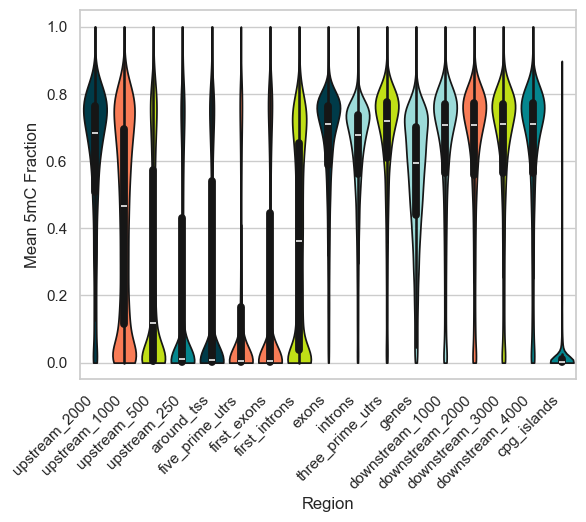

In [51]:
g = sns.violinplot(
    data=df,
    x="Region",
    y="mean_mc",
    hue="Region",
    order=column_order,
    cut=0,
    palette=biomodal_palette,
    saturation=1,
)
g.set_ylabel("Mean 5mC Fraction")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
plt.show()

We see that overall, as we approach the TSS from the upstream regions, the methylation fraction starts to decrease. Each of the subregions of the genome have their own methylation levels, and it slowly increases in the downstream regions to go back to mean background level similar to that of the far-away upstream regions. CpG islands have near-zero methylation levels, as expected.

We can do the same plot for the 5hmC levels. Overall the levels of 5hmC in the genome are much lower than that of 5mC, but a similar trend can be observed.

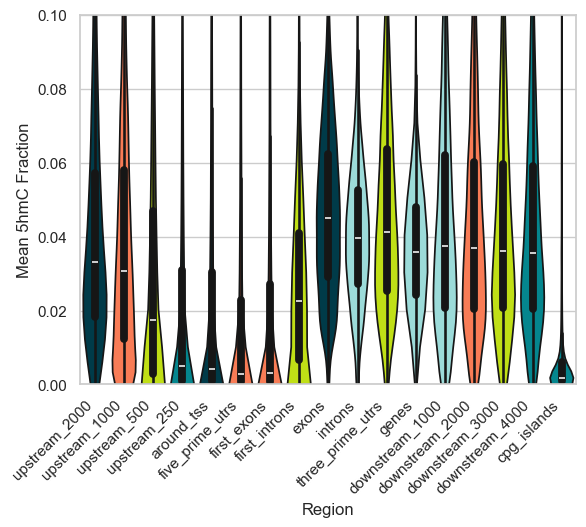

In [52]:
g = sns.violinplot(
    data=df,
    x="Region",
    y="mean_hmc",
    hue="Region",
    order=column_order,
    cut=0,
    palette=biomodal_palette,
    saturation=1,
)
g.set_ylim(0, 0.1)
g.set_ylabel("Mean 5hmC Fraction")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
plt.show()

## Create a final feature set

We want a dataframe containing one line per gene, and where each column is a specific feature (e.g. mean mC fraction at exons, or number of CpGs in the first introns). We want the data to be in this format so that we can easily match it to datasets of gene expression, which will have one expression value per gene.

In [53]:
df_pivot = df.pivot(
    index=["Gene_id", "Gene_name", "contig"],
    # index = ["Transcript_id", "contig"],
    columns="Region",
    values=["mean_mc", "mean_hmc", "mean_modc", "cpg_count", "range_length"],
)

In [54]:
df_pivot.head()

mean_mc                           \
Region                                 around_tss cpg_islands downstream_0   
Gene_id               Gene_name contig                                       
ENSMUSG00000000001.4  Gnai3     3        0.000474    0.000370     0.748425   
ENSMUSG00000000003.15 Pbsn      X        0.726073    0.001538     0.631579   
ENSMUSG00000000028.15 Cdc45     16       0.000515    0.001563     0.780788   
ENSMUSG00000000037.17 Scml2     X        0.738338    0.649756     0.783784   
ENSMUSG00000000049.11 Apoh      11       0.003213    0.002429     0.815992   

                                                                        \
Region                                 downstream_1000 downstream_2000   
Gene_id               Gene_name contig                                   
ENSMUSG00000000001.4  Gnai3     3             0.807040        0.706579   
ENSMUSG00000000003.15 Pbsn      X             0.700000             NaN   
ENSMUSG00000000028.15 Cdc45     16            0.664640        0.073536   
ENSMUSG00000000037.17 Scml2     X             0.745455        0.711864   
ENSMUSG00000000049.11 Apoh      11            0.812207             NaN   

                                                                        \
Region                                 downstream_3000 downstream_4000   
Gene_id               Gene_name contig                                   
ENSMUSG00000000001.4  Gnai3     3             0.756383        0.800728   
ENSMUSG00000000003.15 Pbsn      X                  NaN        0.763359   
ENSMUSG00000000028.15 Cdc45     16            0.012273        0.135029   
ENSMUSG00000000037.17 Scml2     X             0.762791        0.532710   
ENSMUSG00000000049.11 Apoh      11            0.754902        0.489796   

                                                                            \
Region                                     exons first_exons first_introns   
Gene_id               Gene_name contig                                       
ENSMUSG00000000001.4  Gnai3     3       0.808834    0.000240      0.581343   
ENSMUSG00000000003.15 Pbsn      X       0.760580    0.726073      0.743142   
ENSMUSG00000000028.15 Cdc45     16      0.569449    0.001155           NaN   
ENSMUSG00000000037.17 Scml2     X       0.762484    0.742297      0.730605   
ENSMUSG00000000049.11 Apoh      11      0.788561    0.826833      0.549999   

                                        ...  range_length                  \
Region                                  ... first_introns five_prime_utrs   
Gene_id               Gene_name contig  ...                                 
ENSMUSG00000000001.4  Gnai3     3       ...       22051.0           140.0   
ENSMUSG00000000003.15 Pbsn      X       ...        5295.0           139.0   
ENSMUSG00000000028.15 Cdc45     16      ...          15.0           311.0   
ENSMUSG00000000037.17 Scml2     X       ...       34668.0             NaN   
ENSMUSG00000000049.11 Apoh      11      ...       51939.0            50.0   

                                                                             \
Region                                     genes   introns three_prime_utrs   
Gene_id               Gene_name contig                                        
ENSMUSG00000000001.4  Gnai3     3        38866.0   13562.0           2054.0   
ENSMUSG00000000003.15 Pbsn      X        15722.0    9532.0            235.0   
ENSMUSG00000000028.15 Cdc45     16       31540.0   29402.0            127.0   
ENSMUSG00000000037.17 Scml2     X       175688.0  138112.0              NaN   
ENSMUSG00000000049.11 Apoh      11       71042.0   17921.0            100.0   

                                                                    \
Region                                 upstream_1000 upstream_1500   
Gene_id               Gene_name contig                               
ENSMUSG00000000001.4  Gnai3     3              500.0         500.0   
ENSMUSG00000000003.15 Pbsn      X              500.0         500.0   
ENSMUS

In [55]:
df_features = df_pivot.copy()

In [56]:
df_features.columns = [" ".join(col).strip() for col in df_features.columns.values]

In [57]:
features = df_features.columns

In [58]:
# replace white spaces with underscores in features
features = [f.replace(" ", "_") for f in features]
df_features.columns = features

The above dataframe is our feature set, containing a series of features (mean 5mC, mean 5hmC, mean modC, CpG count, and region length) for each of the genomic regions of interest, and for each gene.

## Write to file

Finally, we write this feature file as a pickle file, which preserves the variable type, and is therefore prefered over a more basic text file.

In [59]:
df_features = df_features.reset_index()
df_features.head()

,Gene_id,Gene_name,contig,mean_mc_around_tss,mean_mc_cpg_islands,mean_mc_downstream_0,mean_mc_downstream_1000,mean_mc_downstream_2000,mean_mc_downstream_3000,mean_mc_downstream_4000,...,range_length_first_introns,range_length_five_prime_utrs,range_length_genes,range_length_introns,range_length_three_prime_utrs,range_length_upstream_1000,range_length_upstream_1500,range_length_upstream_2000,range_length_upstream_250,range_length_upstream_500
0,ENSMUSG00000000001.4,Gnai3,3,0.000474,0.000370,0.748425,0.807040,0.706579,0.756383,0.800728,...,22051.0,140.0,38866.0,13562.0,2054.0,500.0,500.0,500.0,250.0,250.0
1,ENSMUSG00000000003.15,Pbsn,X,0.726073,0.001538,0.631579,0.700000,NaN,NaN,0.763359,...,5295.0,139.0,15722.0,9532.0,235.0,500.0,500.0,500.0,250.0,250.0
2,ENSMUSG00000000028.15,Cdc45,16,0.000515,0.001563,0.780788,0.664640,0.073536,0.012273,0.135029,...,15.0,311.0,31540.0,29402.0,127.0,500.0,500.0,500.0,250.0,250.0
3,ENSMUSG00000000037.17,Scml2,X,0.738338,0.649756,0.783784,0.745455,0.711864,0.762791,0.532710,...,34668.0,NaN,175688.0,138112.0,NaN,500.0,500.0,500.0,250.0,250.0
4,ENSMUSG00000000049.11,Apoh,11,0.003213,0.002429,0.815992,0.812207,NaN,0.754902,0.489796,...,51939.0,50.0,71042.0,17921.0,100.0,500.0,500.0,500.0,250.0,250.0


In [60]:
# add a column with a boolean depending on whether the transcript is is selected_transcripts or not
df_features["selected_transcript"] = df_features.Gene_id.isin(selected_transcripts.gene_id)

In [61]:
df_features.columns

Index(['Gene_id', 'Gene_name', 'contig', 'mean_mc_around_tss',
       'mean_mc_cpg_islands', 'mean_mc_downstream_0',
       'mean_mc_downstream_1000', 'mean_mc_downstream_2000',
       'mean_mc_downstream_3000', 'mean_mc_downstream_4000', 'mean_mc_exons',
       'mean_mc_first_exons', 'mean_mc_first_introns',
       'mean_mc_five_prime_utrs', 'mean_mc_genes', 'mean_mc_introns',
       'mean_mc_three_prime_utrs', 'mean_mc_upstream_1000',
       'mean_mc_upstream_1500', 'mean_mc_upstream_2000',
       'mean_mc_upstream_250', 'mean_mc_upstream_500', 'mean_hmc_around_tss',
       'mean_hmc_cpg_islands', 'mean_hmc_downstream_0',
       'mean_hmc_downstream_1000', 'mean_hmc_downstream_2000',
       'mean_hmc_downstream_3000', 'mean_hmc_downstream_4000',
       'mean_hmc_exons', 'mean_hmc_first_exons', 'mean_hmc_first_introns',
       'mean_hmc_five_prime_utrs', 'mean_hmc_genes', 'mean_hmc_introns',
       'mean_hmc_three_prime_utrs', 'mean_hmc_upstream_1000',
       'mean_hmc_upstream_1500',

In [62]:
genes.df.columns

Index(['Chromosome', 'Source', 'Type', 'Start', 'End', 'Score', 'Phase', 'Id',
       'Gene_id', 'Gene_type', 'Gene_name', 'Level', 'Mgi_id', 'Havana_gene',
       'Tag', 'Ranges_ID', 'Region'],
      dtype='object')

In [63]:
df_features = genes.df[["Gene_id", "Chromosome", "Start", "End"]].merge(
    df_features, on="Gene_id", how="left",
    )

In [64]:
df_features

,Gene_id,Chromosome,Start,End,Gene_name,contig,mean_mc_around_tss,mean_mc_cpg_islands,mean_mc_downstream_0,mean_mc_downstream_1000,...,range_length_five_prime_utrs,range_length_genes,range_length_introns,range_length_three_prime_utrs,range_length_upstream_1000,range_length_upstream_1500,range_length_upstream_2000,range_length_upstream_250,range_length_upstream_500,selected_transcript
0,ENSMUSG00000025903.14,1,4807787,4848409,Lypla1,1,0.000410,0.000327,NaN,0.555201,...,90.0,40622.0,38089.0,1722.0,500.0,500.0,500.0,250.0,250.0,True
1,ENSMUSG00000104217.1,1,4807891,4886769,Gm37988,1,0.000334,0.000327,0.744035,0.744090,...,NaN,78878.0,57461.0,NaN,500.0,500.0,500.0,250.0,250.0,True
2,ENSMUSG00000033813.15,1,4857813,4897908,Tcea1,1,0.001300,0.000912,0.790541,0.673387,...,99.0,40095.0,28064.0,1540.0,500.0,500.0,500.0,250.0,250.0,True
3,ENSMUSG00000033793.12,1,5070017,5162528,Atp6v1h,1,0.732394,0.001487,0.796095,NaN,...,NaN,92511.0,76589.0,NaN,500.0,500.0,500.0,250.0,250.0,True
4,ENSMUSG00000025905.14,1,5588465,5606130,Oprk1,1,0.228089,0.086337,0.772798,NaN,...,183.0,17665.0,12967.0,3346.0,500.0,500.0,500.0,250.0,250.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21668,ENSMUSG00000094739.2,Y,78835720,78838055,Gm20806,Y,NaN,0.650937,1.000000,NaN,...,398.0,2335.0,NaN,138.0,500.0,500.0,500.0,250.0,250.0,True
21669,ENSMUSG00000095867.2,Y,79148788,79151121,Gm20917,Y,NaN,0.650937,NaN,NaN,...,399.0,2333.0,NaN,138.0,500.0,500.0,500.0,250.0,250.0,True
21670,ENSMUSG00000094660.2,Y,84562571,84564906,Gm21394,Y,NaN,0.650937,NaN,NaN,...,398.0,2335.0,NaN,138.0,500.0,500.0,500.0,250.0,250.0,True
21671,ENSMUSG00000095650.2,Y,85528516,85530907,Gm20854,Y,0.489796,0.650937,0.818182,NaN,...,NaN,2391.0,6.0,NaN,500.0,500.0,500.0,250.0,250.0,True


In [65]:
df_features.to_pickle("features.pickle")

For all 21,673 protein-coding genes in the mm10 genome, this file contains the ID, name, chromosome, start and end, as well as information about each sub-region of the gene (i.e. mean methylation, cpg count, and length of regions such as exons, upstream, etc...). It also contains a transcript ID column to identify the relevant transcript that we kept for each gene.